In [1]:
%matplotlib widget
from __future__ import print_function
from ipywidgets import interact, fixed,Dropdown, ToggleButtons
import yaml
import ipywidgets as widgets
from IPython.display import display, Latex, HTML

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from brdfs import brdf_map
import math
plt.rcParams['text.usetex'] = True


In [11]:
def cartesian_to_spherical(x, y, z):
    theta = np.arctan2(np.sqrt(x**2 + y**2), z)
    phi = np.arctan2(y, x)
    return theta, phi
def rotate_vector(v, axis, angle_rad):
    axis = axis / np.linalg.norm(axis)

    # Compute the cross product matrix of the main axis vector
    axis_cross_matrix = np.array([[0, -axis[2], axis[1]],
                                  [axis[2], 0, -axis[0]],
                                  [-axis[1], axis[0], 0]])

    # Compute the rotation matrix using Rodrigues' rotation formula
    rotation_matrix = np.eye(3) + axis_cross_matrix * math.sin(angle_rad) + np.dot(axis_cross_matrix, axis_cross_matrix) * (1 - math.cos(angle_rad))

    # Apply the rotation matrix to the vector
    rotated_vector = np.dot(rotation_matrix, v)

    return rotated_vector

def calculate_brdf_surface(brdf, sampling_mode, values):
    theta_i = np.deg2rad(values['theta_i'])
    phi_i = np.deg2rad(values['phi_i'])
    thetas = np.arange(0, 89, step=5)
    num_thetas = len(thetas)
    phis = np.arange(0, 359, step=5)
    num_phis = len(phis)
    thetas, phis = np.meshgrid(thetas, phis)

    X = np.zeros((num_phis, num_thetas))
    Y = np.zeros((num_phis, num_thetas))
    Z = np.zeros((num_phis, num_thetas))
    normal = np.array([0,0,1])
    binormal = np.array([0,1,0])
    for i in range(num_phis):
        for j in range(num_thetas):
            
            theta = np.deg2rad(thetas[i, j])
            phi = np.deg2rad(phis[i, j])
            if sampling_mode == 'Naive':
                theta_o = theta
                phi_o = phi    

                incoming = np.array((np.sin(theta_i)*np.cos(phi_i), np.sin(theta_i)*np.sin(phi_i), np.cos(theta_i)))
                incoming = incoming / np.linalg.norm(incoming)
                outgoing = np.array((np.cos(phi)*np.sin(theta), np.sin(phi)*np.sin(theta), np.cos(theta)))
                outgoing = outgoing / np.linalg.norm(outgoing)
                half_vector = (incoming + outgoing)
                half_vector = half_vector / np.linalg.norm(half_vector)
                theta_h, phi_h = cartesian_to_spherical(half_vector[0],half_vector[1],half_vector[2])
                d = rotate_vector(rotate_vector(incoming, normal, -phi_h), binormal, -theta_h)
                d = d / np.linalg.norm(d)
                theta_d, phi_d = cartesian_to_spherical(d[0],d[1],d[2])

            else:
                theta_h = theta
                phi_h = phi
                theta_d = theta_i
                phi_d = phi_i

                half_vector = np.array((np.sin(theta_h)*np.cos(phi_h), np.sin(theta_h)*np.sin(phi_h), np.cos(theta_h)))
                half_vector = half_vector/ np.linalg.norm(half_vector)

                d = np.array((np.sin(theta_d)*np.cos(phi_d), np.sin(theta_d)*np.sin(phi_d), np.cos(theta_d)))
                d = d / np.linalg.norm(d)
                
                incoming = rotate_vector(rotate_vector(d,binormal, theta_h), normal, phi_h)
                incoming = incoming / np.linalg.norm(incoming)
                theta_i, phi_i = cartesian_to_spherical(incoming[0], incoming[1], incoming[2])

                outgoing = 2*(np.dot(incoming,half_vector))*half_vector - incoming
                outgoing = outgoing / np.linalg.norm(outgoing)
                theta_o, phi_o = cartesian_to_spherical(outgoing[0],outgoing[1],outgoing[2])
                
            
            radius = brdf(theta_i,phi_i,theta_o,phi_o,theta_h,phi_h,theta_d,phi_d, parameters=values)
            X[i, j] = radius * outgoing[0]
            Y[i, j] = radius * outgoing[1]
            Z[i, j] = radius * outgoing[2]
    ray = [[0,incoming[0]], [0,incoming[1]], [0,incoming[2]]]
    return X, Y, Z, ray

def plot_brdf(ax,material,sampling_mode, values):
    ax.clear()
    ax.axes.set_xlim3d(left=-1, right=1) 
    ax.axes.set_ylim3d(bottom=-1, top=1) 
    ax.axes.set_zlim3d(bottom=0, top=1) 
    X,Y,Z, incoming = calculate_brdf_surface(brdf_map.get(material),sampling_mode, values)
    ax.plot_surface(X, Y, Z)
    ax.plot(incoming[0], incoming[1], incoming[2], c='r')
    return

interactive(children=(Dropdown(description='material', options=('Lambertian', 'Phong', 'Torrance-Sparrow', 'Co…

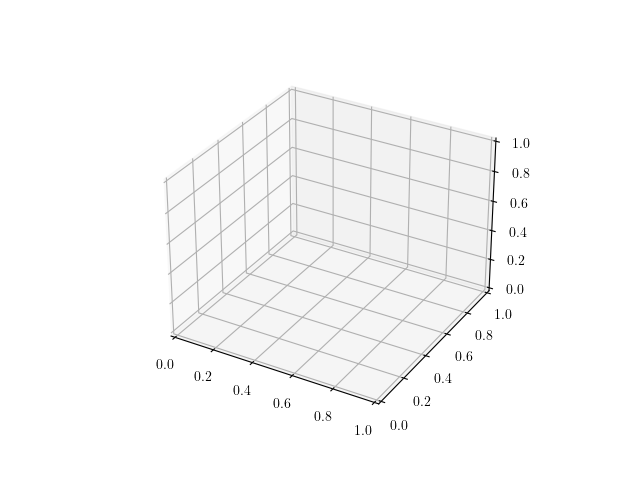

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
with open('config.yaml','r') as f:
    data = yaml.load(f, Loader=yaml.FullLoader)

@interact
def select_material(material=Dropdown(options=brdf_map.keys())):
    def handle_slider_change(change):
        values = [alpha.value for alpha in alphas]
        plot_brdf(ax,material,button.value,dict(zip(list(material_params.keys()) + ['theta_i']+['phi_i'],values)))
    # create sliders
    material_params = data.get(material)
    alphas = [
        widgets.FloatSlider(min=material_params.get(i)[0], max=material_params.get(i)[1], step=1e-2, description=rf'$\{i}$', orientation='horizontal')
        for i in data.get(material)
    ]
    alphas.append(widgets.IntSlider(min=-89, max=89, step=1, description=rf'$\theta_i$', orientation='horizontal'))
    alphas.append(widgets.IntSlider(min=0, max=359, step=1, description=rf'$\phi_i$', orientation='horizontal'))


    button = ToggleButtons(
        options=['Naive', 'Rusinkiewicz'],
        description='Sampling Mode:',
        button_style='',
        disabled=False,
        layout={'width': '250px'}
        )

    for widget in alphas:
        widget.observe(handle_slider_change, names='value')
    # display ui
    ui = widgets.HBox(alphas)
    caption = widgets.Label(value='No change was made yet.')
    display(ui)
    display(button)